In [2]:
#importing all of the libraries
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
#import IPython’s display module to aid us in plotting images to the screen later.
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [4]:
# ------------  Deep Q-Network  -------------------------
"""
DQN will receive screenshot-like images of the cart and pole environment as input, 
so to create a DQN object, require the height and width of the image input that will be coming in to this model.
"""
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        # PyTorch refers to fully connected layers as Linear layers
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)#image of three main colors is the input
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)#two because there are two actions left and right
        
    def forward(self, t):
        #t is a tensor passed
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t    

In [5]:
# ------------------------ Experience ----------------------------------
"""
experiences from replay memory is use to train our network.
creating a class called Experience. This class will be used 
to create instances of Experience objects that will get stored in and sampled from replay memory later.
"""
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)
# namedtuple(), which is a Python function for creating tuples with named fields.
"""
e = Experience(2,3,1,4) 
e
"""

'\ne = Experience(2,3,1,4) \ne\n'

In [6]:
# ------------------------- Replay Memory -----------------------------
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] # structure that actually holds the stored experiences.
        self.push_count = 0 # to keep track of how many experiences we’ve added to memory.
        
    # way to store experiences in replay memory as they occur
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience) #if the memory is not full
        else:
            self.memory[self.push_count % self.capacity] = experience # if the memory is full then push to the oldest memory
        self.push_count += 1
        
    # this is to randomly get the experiences to train the dqn and the no.of experinces = batch size    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)    
    
    # to check whether that there are sufficient no.of experinces in the memory greater or equal to the batch size
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [7]:
# --------------------------- Epsilon Greedy Strategy -------------------------------
# exploration rate ----> epsilon
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        # starting, ending, and decay values of epsilon
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        # returns the calculated exploration rate according to the current step of the agent
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)    

In [8]:
# ----------------------- Reinforcement Learning Agent -----------------------------------
""" when create an Agent object, need to already have an instance of EpsilonGreedyStrategy
    num_actions -- how many possible actions can the agent take from a given state.
"""    

class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device # device will be the device that PyTorch use for tensor calculations --> CPU or GPU.
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step) # current step is given and get the exploration rate
        self.current_step += 1 # then increase the current step
        
        # just considering a random number between(0,1) to compare the rate
        if rate > random.random():
            #return random.randrange(self.num_actions) # explore
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore
        else:
            with torch.no_grad():
                """
                to turn off gradient tracking since currently using the model for inference and not training.
                
                During training PyTorch keeps track of all the forward pass calculations that happen within the network. 
                It needs to do this so that it can know how to apply backpropagation later. 
                Since we’re only using the model for inference at the moment, we’re telling PyTorch not to keep track of 
                any forward pass calculations.
                """
                #return policy_net(state).argmax(dim=1).item() 
                # using the nn we choose the q* (before for this use q table)
                return policy_net(state).argmax(dim=1).to(self.device)# exploit - get the q*(s,a) from that state 

In [9]:
# ---------------------------------- Environment Manager -----------------------------------------
"""
manage the environment and process images that will be passed to our deep Q-network as input.
manage our cart and pole environment.
"""

class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped # gives access to behind-the-scenes dynamics of the environment that wouldn’t have access.
        self.env.reset()
        """
        when it’s set to None, that indicates that we’re at the start of an episode and have not
        yet rendered the screen of the initial observation.
        """
        self.current_screen = None # current_screen will track the current screen of the environment at any given time
        self.done = False # done will track whether or not any taken action has ended an episode.
        
    def reset(self):
        # reset the env
        self.env.reset()
        self.current_screen = None # reset the env and then render current screen to none to start the env screen again

    def close(self):
        # close the env
        self.env.close()

    def render(self, mode='human'):
        # to display the env
        return self.env.render(mode)    
    
    # Number Of Actions Available To Agent
    def num_actions_available(self):
        # no.of actions have to be taken from the actions space of the given gym env
        return self.env.action_space.n
    
    # Taking An Action In The Environment
    def take_action(self, action):   
        # this is the place where our agent takes actions and the return from theis step() is 
        # observation, reward,done,info here we consider only two
        # using step() function the agent takes actions
        _, reward, self.done, _ = self.env.step(action.item())
        # value of the action is taken from the .item and then pass to the step to create a tensor 
        # as we are working with tensors in this code
        return torch.tensor([reward], device=self.device)
    
    # Starting An Episode
    # returns True when the current_screen is None and returns False otherwise.
    def just_starting(self):
        # when reseting we set the current screen to none which means that here we start a new episode
        return self.current_screen is None
    
    # Getting The State Of The Environment
    # return the current state of the environment in the form of a processed image of the screen.
    # deep Q-network takes states of the environment as input, and previously mentioned that for environment, 
    # states would be represented using screenshot-like images.
    # represent a single state in the environment as the difference between the current screen and the previous screen
    # This will allow the agent to take the velocity of the pole into account from one single image
    # single state will be represented as a processed image of the difference between two consecutive screens.
    def get_state(self):
        if self.just_starting() or self.done:
            # as we try to get the difference of two ss and at begining there is no previous ss so we return black screen
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            # if at the mid of a episode get the difference of two ss
            s1 = self.current_screen# currrent screen
            s2 = self.get_processed_screen()# this is the last screen
            self.current_screen = s2
            return s2 - s1
     
    # Get Processed Screen Dimensions
    def get_screen_height(self):
        screen = self.get_processed_screen()
        # screen.shape[1] stands for the no.of channels of the image
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3] 
    
    # Processing The Screen Image
    """
    transposed,cropped and transformed version of the original screen returned by gym is returned by get_processed_screen()
    """
    def get_processed_screen(self):
        # as our dqn expects tensors convert the array into order ---> (channels x height x width)
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    # Crop Screen Image
    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    # Convert And Rescale Screen Image Data
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)
    
# -------------------- finished up with the our CartPoleEnvManager class    

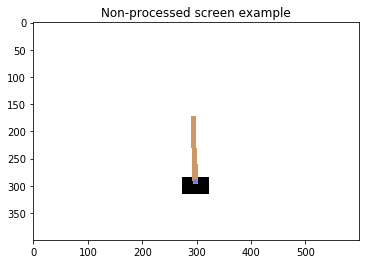

In [10]:
# Non-Processed Screen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")# the device is defined
em = CartPoleEnvManager(device) # the device is sent to the constructor of the class
em.reset() # reset the environment
screen = em.render('rgb_array')# 'rgb_array'

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

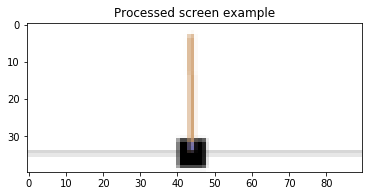

In [10]:
# Processed Screen
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

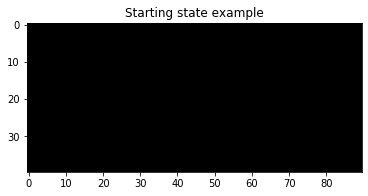

In [11]:
# Starting State
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


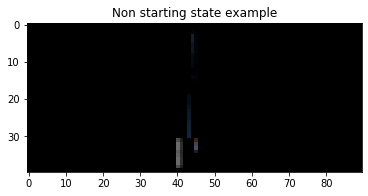

In [12]:
# Non-Starting State
for i in range(5):
    # come to the middle of an episode to  check and we have done 5 actions so self.done ~= 0 so it is in the middle
    em.take_action(torch.tensor([1]))
screen = em.get_state()
# now can see the differnce as black areas are zero values as no difference and the change of 
# the pole posittion can be seen 

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

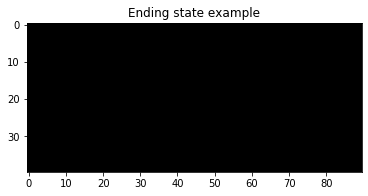

In [13]:
# Ending State
em.done = True # as self.done = 0 then it is ending the episode and screen should be black
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

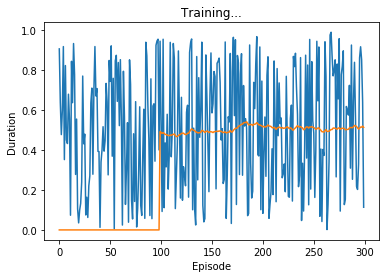

Episode 300 
 100 episode moving avg: 0.5136364


In [14]:
# Utility Functions  --> plot performances on a chart.
"""
To solve cart and pole, the average reward must be greater than or equal to 195 over 100 consecutive episodes. 
Recall that agent gets a reward of +1 for each step it takes that doesn’t end the episode.
So, the duration of an episode measured in timesteps is exactly equivalent to the reward for that episode.
"""

def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float) # transform the values to a PyTorch tensor
    
    # can’t calculate a moving average of a data set when the data set is not at least as large as the period 
    # that want to calculate the moving average for.
    # this means that our values or time should be atleast equal to the period we given
    # For example, if want to calculate the 100-period moving average of episode durations, 
    # then if have only played 90 episodes, a 100-period moving average can’t be calculated.
    
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)#even greater size=period 
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))# concatanate with zero tensor
        # as we want to get the average of 100 then the first 99 is neglected and value start from the 100 and then go
        #print(moving_avg)
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))# if lesser than period then zeros
        return moving_avg.numpy() 
    
plot(np.random.rand(300), 100)    

In [15]:
# -------------------------- Tensor Processing ------------------------------

def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))
    
    # return seperate tensors for these
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    # return a tuple that contains the states tensor, actions tensor, rewards tensor, and next_states tensor.
    return (t1,t2,t3,t4)

In [16]:
# ------------------------------ Calculating Q-Values --------------------------

# calculate the q-values for the current states using the policy_net, and the next states using the target_net.

class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # create static methods donot want to create methods for this class so define a device in this class itself
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)# if in final state of an episode values are zero
        non_final_state_locations = (final_state_locations == False) # if not at the end of an episode otherwise values are zero as black screen
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)# initialize to zero as zero for the final states
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()# set the values to the max values
        return values

In [17]:
""" ======================  Main Program ================================= 

1.Initialize replay memory capacity.
2.Initialize the policy network with random weights.
3.Clone the policy network, and call it the target network.
4.For each episode:
    1.Initialize the starting state.
    2.For each time step:
        1.Select an action.
            - Via exploration or exploitation
        2.Execute selected action in an emulator.
        3.Observe reward and next state.
        4.Store experience in replay memory.
        5.Sample random batch from replay memory.
        6.Preprocess states from batch.
        7.Pass batch of preprocessed states to policy network.
        8.Calculate loss between output Q-values and target Q-values.
            - Requires a pass to the target network for the next state
        9.Gradient descent updates weights in the policy network to minimize loss.
            - After x  time steps, weights in the target network are updated to the weights in the policy network.
"""

' ======================  Main Program ================================= \n\n1.Initialize replay memory capacity.\n2.Initialize the policy network with random weights.\n3.Clone the policy network, and call it the target network.\n4.For each episode:\n    1.Initialize the starting state.\n    2.For each time step:\n        1.Select an action.\n            - Via exploration or exploitation\n        2.Execute selected action in an emulator.\n        3.Observe reward and next state.\n        4.Store experience in replay memory.\n        5.Sample random batch from replay memory.\n        6.Preprocess states from batch.\n        7.Pass batch of preprocessed states to policy network.\n        8.Calculate loss between output Q-values and target Q-values.\n            - Requires a pass to the target network for the next state\n        9.Gradient descent updates weights in the policy network to minimize loss.\n            - After x  time steps, weights in the target network are updated to the we

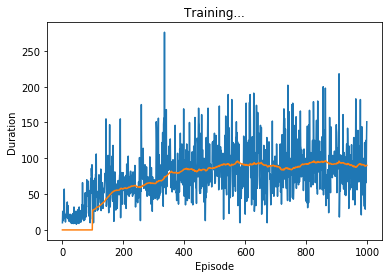

Episode 1000 
 100 episode moving avg: 90.07


In [18]:
# ------------------------ Hyperparameters ------------------------------

batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
# how frequently,in terms of episodes, update the target network weights with the policy network weights.
# update the target network every 10 episodes.
target_update = 10 
memory_size = 100000 # capacity of the replay memory
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use a GPU if it’s available, otherwise use the CPU.

# creating objects
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

# define both our policy network and target network by creating two instances of our DQN class and passing in the 
# height and width of the screen to set up the appropriate input shape of the networks. 
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
# set the weights and biases in the target_net to be the same as those in the policy_net
target_net.load_state_dict(policy_net.state_dict())
# put the target_net into eval mode, which tells PyTorch that this network is not in training mode.
target_net.eval()
# accepts 'policy_net.parameters()' to optimize, and defined learning rate lr.
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

# -------------------------- Training Loop -----------------------------------
# storing episode_durations during training in order to plot them using the plot() function developed last time
episode_durations = []

for episode in range(num_episodes):
    em.reset() # reset the environment, then get the initial state.
    state = em.get_state() # getting black screen
    
    # nested for loop that will iterate over each time step within each episode.
    for timestep in count():
        action = agent.select_action(state, policy_net)# select action according to the current state
        # according to the action taken get the reward and the next_state
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward)) # push to memory replay
        state = next_state # go to next state
        
        # -----------------------------------
        # in DeepMind's paper policy net takes mini batches from the replay memory at a given frequency.
        # here it is not.
        # -----------------------------------
        # check whether that the replay memory has sufficient no.of memories to train the policy_net
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size) # give the batch size to take batch of experiences
            states, actions, rewards, next_states = extract_tensors(experiences) # get the seperate tensors

            # get the q values returned as a PyTorch tensor
            # ------ current_q_values-------
            current_q_values = QValues.get_current(policy_net, states, actions) 
            # using the target network get the next state q values(usually tensors) and send to the bellman's equation
            # maximum q values are returned from this function as they needed for the bellman's equation
            next_q_values = QValues.get_next(target_net, next_states)
            # -------- target_q_values ---------- 
            target_q_values = (next_q_values * gamma) + rewards # bellman

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))# get the difference or loss/ mean square err
            # before backpropergation occur make all weights to zero if donot happen it will take all the gradients to a count
            # pytorch automatically get the weights and bias values and therefore we donot retain then
            optimizer.zero_grad()
            # computes the gradient of the loss with respect to all the weights and biases in the policy_net.
            loss.backward()
            # updates the weights and biases with the gradients that were computed when we called backward() on our loss.
            optimizer.step()
            
        if em.done:
            # if the episode is over done = 1
            episode_durations.append(timestep) # add the episode duration 
            plot(episode_durations, 100)
            break  
            
    if episode % target_update == 0:
        # from multiple of 10 update the target network
        target_net.load_state_dict(policy_net.state_dict())
            
    # then start a new episode  
em.close()    





